# 3 Vectorization in neural networks (Batchsize)

Huge part of the code has been dervied from the following PyTorch tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
from time import perf_counter, time
import numpy as np # version = 1.24.3
import torch # version = 2.0.0 + cu118
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import random
from tqdm.notebook import tqdm

## Load Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

take_indices_train = list(range(0, len(trainset), 3))
take_indices_valid = list(range(1, len(testset), 2))

train_subset = torch.utils.data.Subset(trainset, take_indices_train)
valid_subset = torch.utils.data.Subset(testset, take_indices_valid)
# trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testloader = torch.utils.data.DataLoader(valid_subset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(len(train_subset))

Files already downloaded and verified
Files already downloaded and verified
16667


### Inspect Dataset

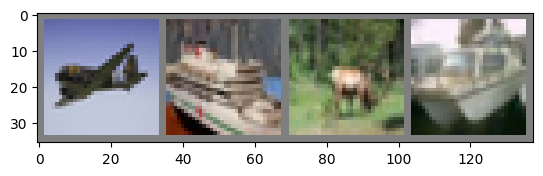

plane ship  deer  ship 


In [21]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define model and training params

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [4]:
NUM_EPOCHS = 10

loss_epoch_bs = []
valid_accuracy_bs = []
time_for_epoch_bs = []

BATCHSIZE = [4, 16, 64, 256, 512]
for bs in BATCHSIZE:
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=bs,
                                            shuffle=True, num_workers=4)

    testloader = torch.utils.data.DataLoader(valid_subset, batch_size=bs,
                                            shuffle=False, num_workers=4)

    device = torch.device("cuda")
    net = Net()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    loss_epoch = []
    valid_accuracy = []
    time_for_epoch = []

    for epoch in tqdm(range(NUM_EPOCHS)):  # loop over the dataset multiple times
        running_loss = 0.0
        total = 0
        correct = 0
        _t_start = perf_counter()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
        _t_end = perf_counter()
        time_for_epoch.append(_t_end - _t_start)
        loss_epoch.append(running_loss)

        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    # calculate outputs by running images through the network
                    outputs = net(images)

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc_epoch = 100 * correct // total
        print(f"epoch: {epoch}, val accuracy: {val_acc_epoch}")
        valid_accuracy.append(val_acc_epoch)
    
    loss_epoch_bs.append(loss_epoch)
    valid_accuracy_bs.append(valid_accuracy)
    time_for_epoch_bs.append(time_for_epoch)

print('Finished Training')

print(time_for_epoch)
print(valid_accuracy)
print(loss_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, val accuracy: 32
epoch: 1, val accuracy: 42
epoch: 2, val accuracy: 51
epoch: 3, val accuracy: 52
epoch: 4, val accuracy: 53
epoch: 5, val accuracy: 56
epoch: 6, val accuracy: 56
epoch: 7, val accuracy: 56
epoch: 8, val accuracy: 55
epoch: 9, val accuracy: 55
Finished Training
[29.21047820005333, 27.47360160003882, 26.758067800023127, 27.290569200005848, 26.67427920002956, 26.77617620001547, 27.168690900027286, 28.565165999985766, 29.173592099978123, 28.849939599982463]
[32, 42, 51, 52, 53, 56, 56, 56, 55, 55]
[8537.221135377884, 6798.643541991711, 6014.0468056201935, 5526.550043463707, 5157.844285964966, 4796.13641217351, 4501.189363270998, 4185.217978969216, 3902.33174431324, 3604.2175880670547]


## Plotting
Saving data in excel and then plotting here

Batchsize: 2, Min Loss: 16085.637818098068, Max valid accuracy: 54, Mean time per epoch: 45.03332194001414
Batchsize: 4, Min Loss: 14416.870352268219, Max valid accuracy: 56, Mean time per epoch: 27.79405608001398
Batchsize: 8, Min Loss: 17699.29439997673, Max valid accuracy: 54, Mean time per epoch: 20.723724949994356
Batchsize: 16, Min Loss: 21182.781938552856, Max valid accuracy: 53, Mean time per epoch: 15.475105129985604
Batchsize: 64, Min Loss: 32020.96647644043, Max valid accuracy: 31, Mean time per epoch: 12.839642409991939
Batchsize: 256, Min Loss: 38722.65985107422, Max valid accuracy: 15, Mean time per epoch: 11.80236194000463


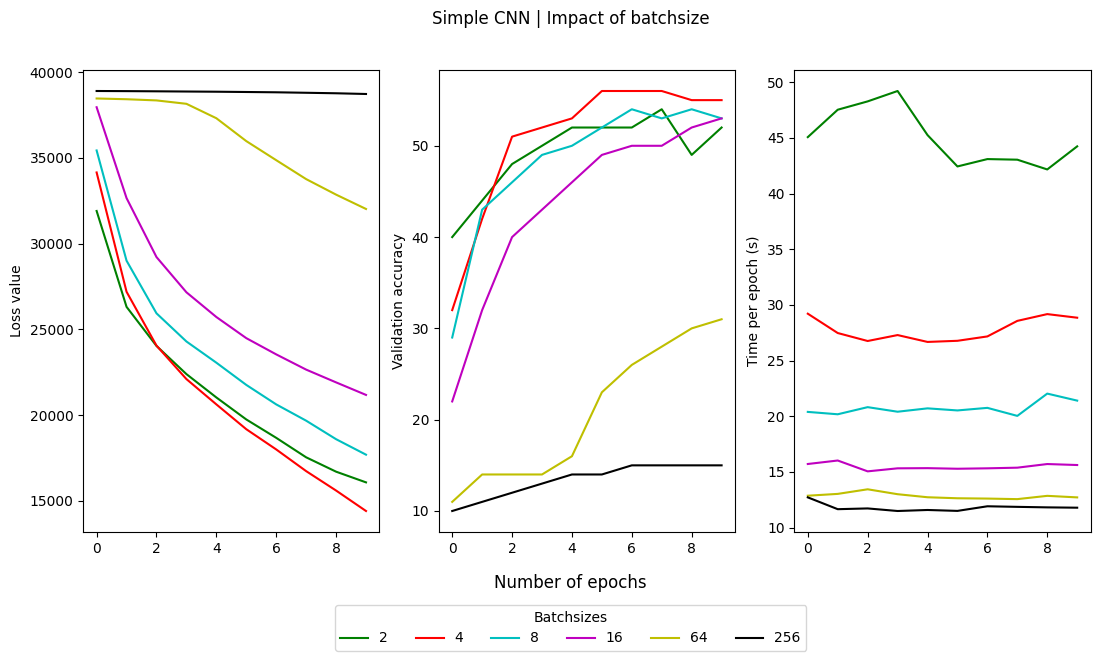

In [33]:
data = {
    2: {
        "Loss": [15952.156147003174, 13157.567764282227, 12020.031846046448, 11198.138070821762, 10517.701076447964, 9876.3598600626, 9340.831995606422, 8772.902255117893, 8354.496323108673, 8042.818909049034],
        "Valid_Accuracy": [40, 44, 48, 50, 52, 52, 52, 54, 49, 52] ,
        "Time_per_epoch": [45.06991880002897, 47.531022000010125, 48.280110399995465, 49.21296029997757, 45.2541311000241, 42.4357553999871, 43.09750640002312, 43.04379790002713, 42.16729110002052, 44.24072600004729] 
    },
    4: {
        "Loss": [8537.221135377884, 6798.643541991711, 6014.0468056201935, 5526.550043463707, 5157.844285964966, 4796.13641217351, 4501.189363270998, 4185.217978969216, 3902.33174431324, 3604.2175880670547],
        "Valid_Accuracy": [32, 42, 51, 52, 53, 56, 56, 56, 55, 55],
        "Time_per_epoch": [29.21047820005333, 27.47360160003882, 26.758067800023127, 27.290569200005848, 26.67427920002956, 26.77617620001547, 27.168690900027286, 28.565165999985766, 29.173592099978123, 28.849939599982463]
    },
    8: {
        "Loss": [4428.972015380859, 3625.7525800466537, 3242.3545240163803, 3037.2198041677475, 2882.65212225914, 2720.8313574790955, 2578.7904075682163, 2460.123455286026, 2325.319326788187, 2212.4117999970913],
        "Valid_Accuracy": [29, 43, 46, 49, 50, 52, 54, 53, 54, 53],
        "Time_per_epoch": [20.389741499966476, 20.176191699982155, 20.81613320001634, 20.40582860005088, 20.707831399980932, 20.521368100016844, 20.752416200004518, 20.03066950000357, 22.033425399975386, 21.403643899946474] 
    },
    16: {
        "Loss": [2371.9469771385193, 2040.8898655176163, 1826.1296372413635, 1697.7860528230667, 1607.7106441259384, 1530.7477850914001, 1471.6065484285355, 1416.1026451587677, 1369.596887588501, 1323.9238711595535],
        "Valid_Accuracy": [22, 32, 40, 43, 46, 49, 50, 50, 52, 53] ,
        "Time_per_epoch": [15.710115599969868, 16.023054199991748, 15.049461799964774, 15.321518799988553, 15.336987900023814, 15.283584599965252, 15.321794699993916, 15.379991099995095, 15.706364799989387, 15.618177799973637] 
    },
    64: {
        "Loss": [600.9510655403137, 600.2658658027649, 599.1898894309998, 596.1019265651703, 582.9608707427979, 562.1368412971497, 544.7617032527924, 527.5234583616257, 513.392126083374, 500.3276011943817],
        "Valid_Accuracy": [11, 14, 14, 14, 16, 23, 26, 28, 30, 31] ,
        "Time_per_epoch": [12.861581599980127, 13.025183199963067, 13.438129499962088, 12.996883500018157, 12.72336910001468, 12.6322062999825, 12.604110100015532, 12.554656699998304, 12.849772599991411, 12.710531499993522] 
    },
    256: {
        "Loss": [151.94062614440918, 151.91114258766174, 151.8696391582489, 151.82193875312805, 151.77788662910461, 151.71284890174866, 151.6456320285797, 151.53733682632446, 151.42343044281006, 151.26039004325867],
        "Valid_Accuracy": [10, 11, 12, 13, 14, 14, 15, 15, 15, 15],
        "Time_per_epoch": [12.713318900030572, 11.651475400023628, 11.71922899998026, 11.488457500003278, 11.579815900011454, 11.498032800038345, 11.912652099970728, 11.860787299985532, 11.814529199968092, 11.785321300034411]
    },
}
COLORS = ["g", "r", "c", "m", "y", "k"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6))

for index, ((bs, value), color) in enumerate(zip(data.items(), COLORS)):
    scaled_loss = [i*bs for i in value["Loss"]]
    ax1.set_ylabel("Loss value")
    ax1.plot(scaled_loss, label=f"{bs}", color=color)

    ax2.set_ylabel("Validation accuracy")
    ax2.plot(value["Valid_Accuracy"], label=f"{bs}", color=color)

    ax3.set_ylabel("Time per epoch (s)")
    ax3.plot(value["Time_per_epoch"], label=f"{bs}", color=color)

    handles, labels = ax1.get_legend_handles_labels()

    print(f"Batchsize: {bs}, Min Loss: {np.amin(scaled_loss)}, Max valid accuracy: {np.amax(value['Valid_Accuracy'])}, Mean time per epoch: {np.mean(value['Time_per_epoch'])}")

fig.legend(handles, labels, title="Batchsizes", loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=6)

fig.suptitle("Simple CNN | Impact of batchsize")
fig.supxlabel("Number of epochs")
plt.show()